In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

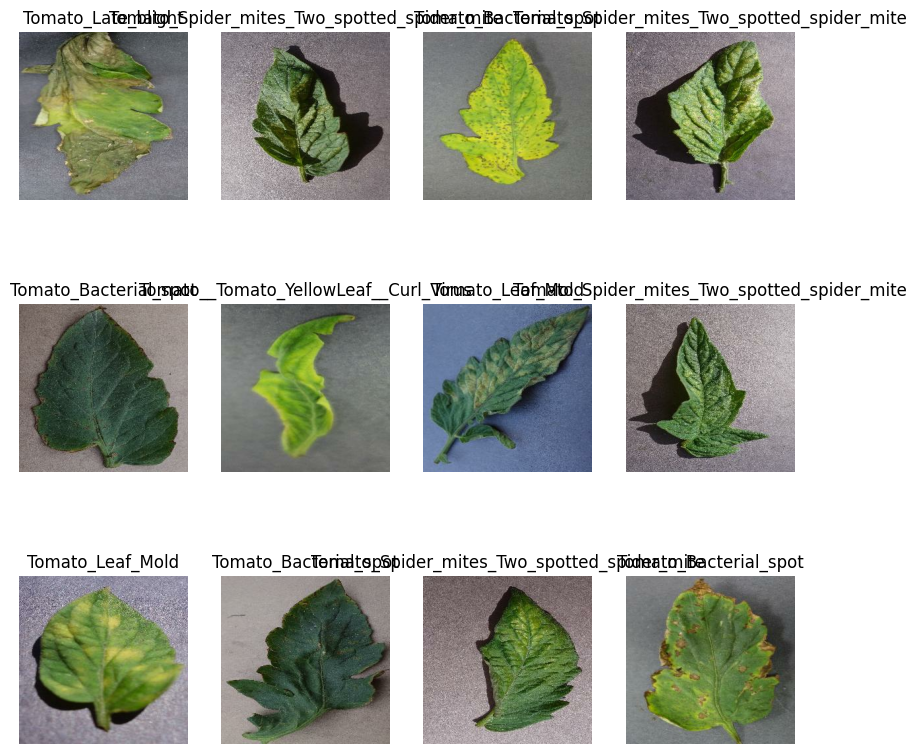

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [35]:
#80% ==>training 20% ==> 10% validation 10% test(TO MEASURE THE ACCURACY) 50 epocs neeche function h iska

In [36]:
train_size = 0.8
len(dataset)*train_size

400.8

In [37]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [38]:
val_size=0.1
len(dataset)*val_size #validation

50.1

In [39]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [40]:
test_ds = test_ds.skip(50)
len(test_ds)  # hardcoded number gives us test ds

51

In [41]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
        
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12) # seed bas random h taki same result na aaye
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)

        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        return train_ds, val_ds, test_ds

In [42]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [43]:
len(train_ds)

400

In [44]:
len(val_ds)

50

In [45]:
len(test_ds)

51

In [46]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#prefetch will load next set of 1000 images if gpu is busy from disk

In [47]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [48]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
#dataset trining ends here next is model building -> rcnn

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    validation_data=val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
    verbose=1,
    epochs=50,
)

Epoch 1/50


ValueError: in user code:

    File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_1' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_1' (type Resizing):
      • inputs=tf.Tensor(shape=(None, None, 256, 256, 3), dtype=float32)


In [53]:
scores = model.evaluate(test_ds)

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\vardh\AppData\Local\Temp\ipykernel_7868\2814678960.py", line 1, in <module>

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1919, in test_step

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "C:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 9 which is outside the valid range of [0, 3).  Label values: 2 5 7 5 4 0 3 7 7 3 0 9 2 5 7 7 7 6 2 0 0 6 8 1 8 0 3 5 4 0 5 7
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_3500]

In [ ]:
scores